<a href="https://colab.research.google.com/github/karans17s/Practical_Implementation_Of_Deep_learning/blob/main/PHASE_3_EXPLORE_PYTORCH_USING_FASHION_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP : 1 == Import req. lib

# PyTorch How to differ from sklearn

### 1) sklearn : traditional ML algo

###  torch : DL model ( nn )

### 2) sklearn : pre-build algo ( high level framework )

### torch : low-level ..

### 3) sklearn : GPU support ( NO )

### torch : GPU support ( YES )

### 4) sklearn : pre-defined ML algo ( limited )

### torch : high customized model architectures

### 5) sklearn : Automatic training with simple function calls

### torch : Manual training with backpropagation




# torch importance

### dataloader -- data pipeline for model training and testing

### torchvision -- easy to access the popular dataset like MNIST , FASHION-MNIST , CIFAR-10 , IMAGENET ( TL )

### .transforms -- ToTensor means converts img to scale 0 to 1.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Step : 2 == download the dataset fashion-mnist

### about fashion-mnist

-- its grayscale imgs of fashion items

-- 28 X 28 grayscale images of 70,000 fashion products from 10 categories, with 7,000 images per category

In [ ]:
training_data = datasets.FashionMNIST(
    root="data", # store
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

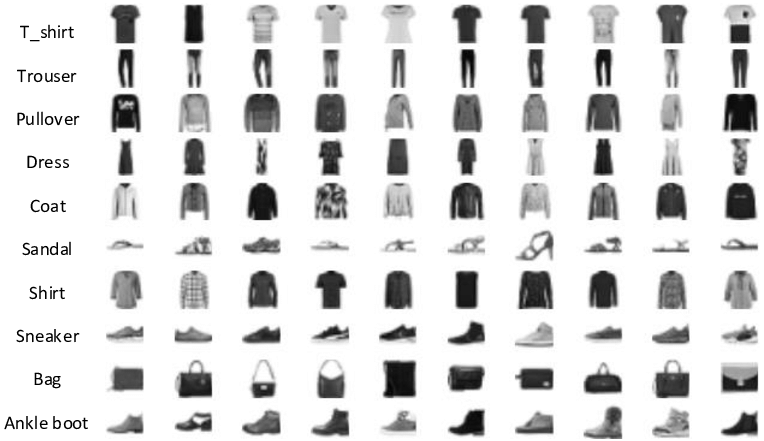

## 1) define the batch size == 64

### It's refer to number of sample processed by model in one iteration

### assume 1000 data sample

### then , ( 1000 / 64 ) --> 16 iteration required in one epoch

### training -- 60,000

### testing -- 10,000

## 2) reason why use?

### memory manage , training speed , SGD

### small batch size -- noisy updates to the model , slower to converge.

### large batch size -- less noise , more memory , risk overfitting



In [ ]:
batch_size = 64

In [ ]:
train_dataloader = DataLoader(
    training_data,
    batch_size=batch_size
    )

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size
    )

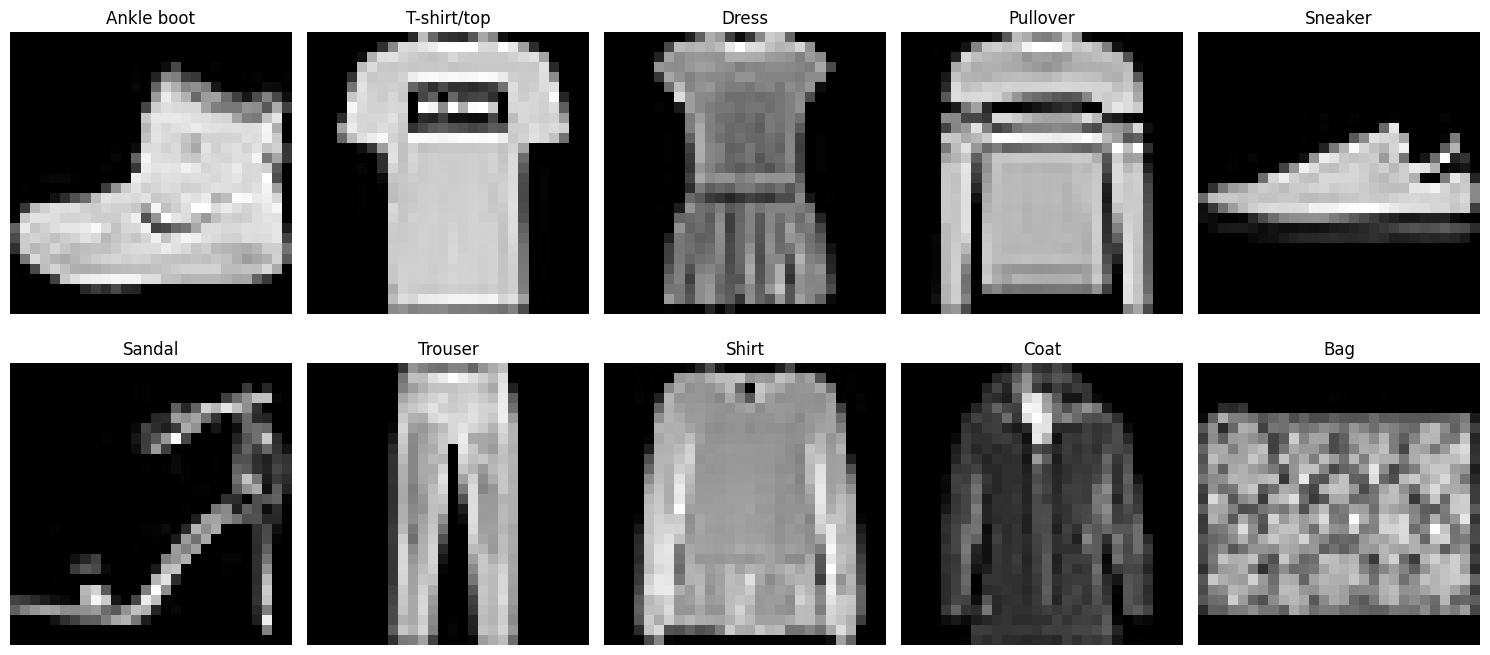

In [ ]:
def plot_all_classes(data, classes):
    # Dictionary to keep track of whether each class has been plotted
    class_seen = {cls: False for cls in range(len(classes))}

    plt.figure(figsize=(15, 7))
    count = 0
    for img, label in data:
        if not class_seen[label]:  # Plot only if the class hasn't been plotted yet
            count += 1
            plt.subplot(2, 5, count)
            plt.imshow(img.squeeze(), cmap="gray")
            plt.title(classes[label])
            plt.axis("off")
            class_seen[label] = True
        if count == len(classes):  # Stop once all classes are plotted
            break
    plt.tight_layout()
    plt.show()

# Define the classes for the FashionMNIST dataset
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_all_classes(training_data, classes)

# Step : 3 == train and test

## x -- input imgs

## y -- target labels

## N -- batch size ( 64 )

## C -- num of channels ( grayscale img -1 )

## H -- ht of img ( 28 )

## W -- Wt of img ( 28 )

In [ ]:
for x, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Step : 4 == Define the device

### CUDA -- NVIDIA GPU ( faster computation )

### MPS -- for MacOS

### CPU -- other cases


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Step : 5 == Define the network

## nn.flatten() -- fully connected layers req. to 1D input so 28 X 28 = 784

## Why use ReLU? -- avoid vanishing Gradients problem , better convergence

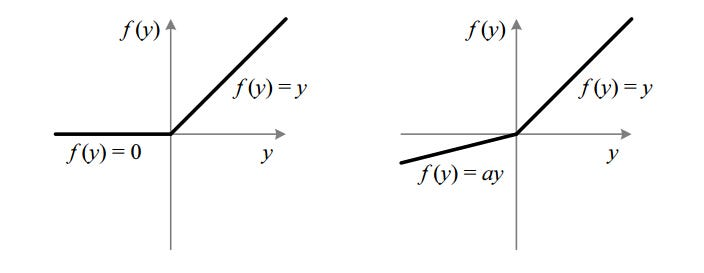

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Step : 6 == optimizing the model parameters

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X) # (batch + 1) --> batch index starting form 0 mostly but we +1 add one and staritng from 1...
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

( batch + 1 ) * len(x) ==> 1 * 64

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Step : 7 == Test Model

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297276  [   64/60000]
loss: 2.286937  [ 6464/60000]
loss: 2.272583  [12864/60000]
loss: 2.273698  [19264/60000]
loss: 2.250774  [25664/60000]
loss: 2.224541  [32064/60000]
loss: 2.232523  [38464/60000]
loss: 2.198076  [44864/60000]
loss: 2.209351  [51264/60000]
loss: 2.171421  [57664/60000]
Test Error: 
 Accuracy: 42.4%, Avg loss: 2.166448 

Epoch 2
-------------------------------
loss: 2.173364  [   64/60000]
loss: 2.165620  [ 6464/60000]
loss: 2.108579  [12864/60000]
loss: 2.130614  [19264/60000]
loss: 2.082304  [25664/60000]
loss: 2.016646  [32064/60000]
loss: 2.051600  [38464/60000]
loss: 1.973509  [44864/60000]
loss: 1.991306  [51264/60000]
loss: 1.907496  [57664/60000]
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.908930 

Epoch 3
-------------------------------
loss: 1.937915  [   64/60000]
loss: 1.912173  [ 6464/60000]
loss: 1.792729  [12864/60000]
loss: 1.837277  [19264/60000]
loss: 1.737975  [25664/60000]
loss: 1.667314  [32064/600

Saving Models

# Step : 8 == Save and load the model

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


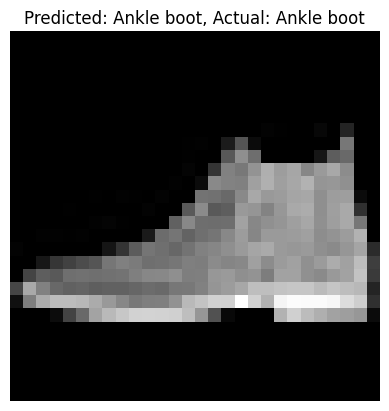

In [ ]:
plt.imshow(x.cpu().squeeze(), cmap="gray")
plt.title(f'Predicted: {predicted}, Actual: {actual}')
plt.axis("off")
plt.show()